In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
DATA = Path("../data")
FIGS = Path("../reports/figures")
DATA.mkdir(exist_ok=True, parents=True)
FIGS.mkdir(exist_ok=True, parents=True)

In [2]:
variants = pd.DataFrame({
    "chrom": ["chr11","chr1","chr11","chr7","chr3","chr11","chr2","chr11"],
    "pos":   [27658369, 10123, 27658370, 5501234, 992211, 27658410, 765432, 27658555],
    "ref":   ["G","A","C","T","G","C","A","G"],
    "alt":   ["A","G","T","C","A","T","G","A"],
    "label": ["benign","pathogenic","benign","pathogenic","benign","pathogenic","benign","pathogenic"]
})
variants.to_csv(DATA/"fake_variants.csv", index=False)
pd.read_csv(DATA/"fake_variants.csv").head()

,chrom,pos,ref,alt,label
0,chr11,27658369,G,A,benign
1,chr1,10123,A,G,pathogenic
2,chr11,27658370,C,T,benign
3,chr7,5501234,T,C,pathogenic
4,chr3,992211,G,A,benign


In [4]:
variants["label"].value_counts()
variants.dtypes

chrom    object
pos       int64
ref      object
alt      object
label    object
dtype: object

In [8]:
df = pd.read_csv(DATA/"fake_variants.csv")

# filter
patho = df[df["label"]=="pathogenic"]

# add a simple feature: transition vs transversion
def is_transition(r,a):
    return int((r,a) in {("A","G"),("G","A"),("C","T"),("T","C")})

df["is_transition"] = [is_transition(r,a) for r,a in zip(df["ref"], df["alt"])]

# counts
df["is_transition"].value_counts()

# groupby example
df.groupby(["chrom","label"])["pos"].count().reset_index(name="n")

,chrom,label,n
0,chr1,pathogenic,1
1,chr11,benign,2
2,chr11,pathogenic,2
3,chr2,benign,1
4,chr3,benign,1
5,chr7,pathogenic,1


In [9]:
df.to_csv(DATA/"fake_variants_clean.csv", index=False)

In [11]:
ann = pd.DataFrame({
    "chrom": ["chr11","chr1","chr11","chr7","chr3","chr11","chr2","chr11"],
    "pos":   [27658369,10123,27658370,5501234,992211,27658410,765432,27658555],
    "consequence": ["missense","synonymous","intron","missense","5_prime_UTR","nonsense","synonymous","intron"],
    "gene": ["BDNF","GENE1","BDNF","CTNNA2","GENE3","BDNF","GENE2","BDNF"]
})
ann.to_csv(DATA/"fake_annotations.csv", index=False)

merged = pd.merge(df, ann, on=["chrom","pos"], how="left")
merged.head()

,chrom,pos,ref,alt,label,is_transition,consequence,gene
0,chr11,27658369,G,A,benign,1,missense,BDNF
1,chr1,10123,A,G,pathogenic,1,synonymous,GENE1
2,chr11,27658370,C,T,benign,1,intron,BDNF
3,chr7,5501234,T,C,pathogenic,1,missense,CTNNA2
4,chr3,992211,G,A,benign,1,5_prime_UTR,GENE3


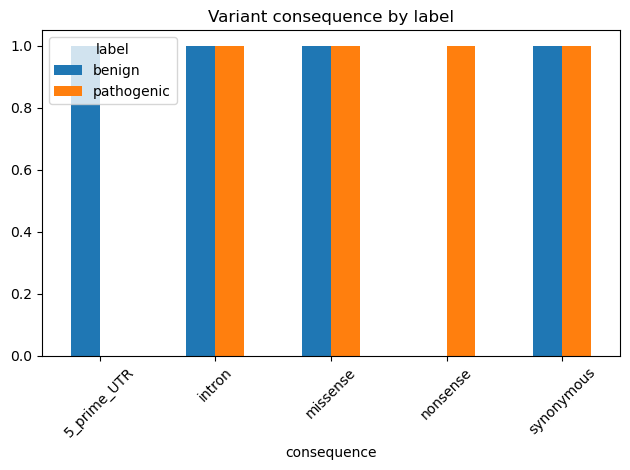

In [13]:
# bar chart: consequence nby Label
ct = pd.crosstab(merged["consequence"], merged["label"])
ax = ct.plot(kind= "bar", rot=45)
plt.title("Variant consequence by label")
plt.tight_layout()
plt.savefig(FIGS/"consequences_by_label.png", dpi=200)
plt.show()

In [16]:
merged["label"].values_counts().plot(kind="pie", autopct="%1.1f%%")
plt.ylabel("")
plt.title("Label distribution")
plt.tight_layout()
plt.savefig(FIGS/"label_distribution.png", dpi=200)
plt.show()

AttributeError: 'Series' object has no attribute 'values_counts'

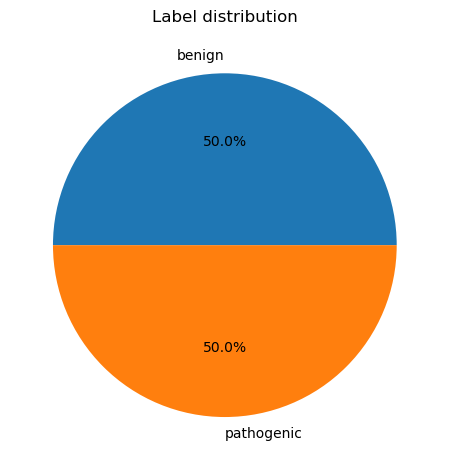

In [17]:
merged["label"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.ylabel("")
plt.title("Label distribution")
plt.tight_layout()
plt.savefig(FIGS/"label_distribution.png", dpi=200)
plt.show()

In [23]:
COMP = {"A":"T","T":"A","C":"G","G":"C"}

def gc_content(seq: str) -> float:
    seq = seq.upper()
    if not seq:
        return 0.0
    g = seq.count("G"); c = seq.count("C")
    return (g + c) / len(seq)

def rev_comp(seq: str) -> str:
    return "".join(COMP.get(b, "N") for b in seq.upper()[::-1])

# sanity checks
assert rev_comp("ACGT") == "ACGT"
assert 0.0 <= gc_content("ACGTAC") <= 1.0

# add a toy sequence column (for practice)
np.random.seed(42)
alphabet = np.array(list("ACGT"))
def random_seq(n=31): 
    return "".join(np.random.choice(alphabet, size=n))
merged["seq31"] = [random_seq(31) for _ in range(len(merged))]
merged["gc31"] = merged["seq31"].apply(gc_content)

merged[["label","gc31"]].groupby("label").mean()


,gc31
label,
benign,0.451613
pathogenic,0.532258


<function matplotlib.pyplot.show(close=None, block=None)>

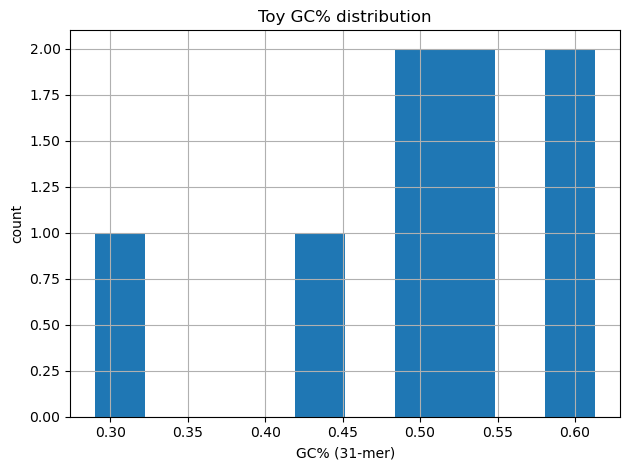

In [25]:
merged["gc31"].hist(bins=10)
plt.xlabel("GC% (31-mer)")
plt.ylabel("count")
plt.title("Toy GC% distribution")
plt.tight_layout()
plt.savefig(FIGS/"gc31_hist.png", dpi=200)
plt.show

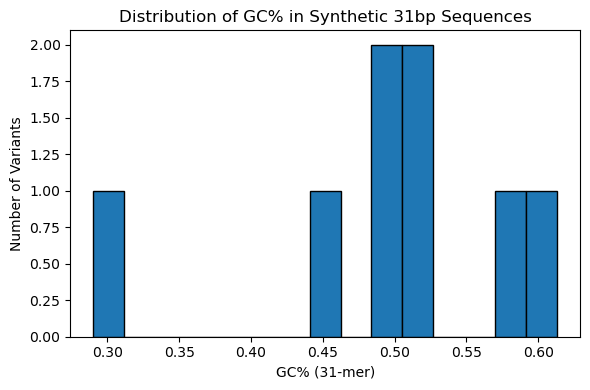

In [26]:
plt.figure(figsize=(6,4))

# Histogram for GC% distribution
merged["gc31"].plot(
    kind="hist",
    bins=15,          # smoother shape
    edgecolor="black" # clean boundaries
)

plt.xlabel("GC% (31-mer)")
plt.ylabel("Number of Variants")
plt.title("Distribution of GC% in Synthetic 31bp Sequences")

# Remove grid
plt.grid(False)

# Tidy layout
plt.tight_layout()

plt.savefig(FIGS/"gc31_hist_clean.png", dpi=200)
plt.show()

In [27]:
merged.to_csv(DATA/"fake_variants_merged.csv", index=False)